In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-tweets/DisasterTweets.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from mpl_toolkits.mplot3d import Axes3D
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from textblob import TextBlob

In [3]:
# load text
filename = '/kaggle/input/disaster-tweets/DisasterTweets.csv'
with open(filename, 'rt', encoding='ISO-8859-1') as file:
    text = file.read()

In [4]:
import string
from nltk.corpus import stopwords
import nltk

# Assuming NLTK stopwords are already downloaded
nltk.download('stopwords')

def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import csv
from collections import Counter

# Function to add words from a document to the vocabulary
def add_doc_to_vocab(text, vocab):
    words = text.split()
    vocab.update(words)

# Function to process CSV files
def process_csv(filename, vocab, is_train):
    with open(filename, 'r', encoding='ISO-8859-1') as file:
        reader = csv.reader(file)
        # Skip header if present
        next(reader, None)
        for row in reader:
            text = row[1]  # Assuming the text is in the second column, adjust as necessary
            if is_train and row[0] == 'cv9':
                continue
            if not is_train and row[0] != 'cv9':
                continue
            add_doc_to_vocab(text, vocab)

# Define vocab
vocab = Counter()
# Add all docs to vocab
process_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', vocab, is_train=True)
# Print the size of the vocab
print("Size of the vocabulary:", len(vocab))
# Print the top words in the vocab
print("Top 50 words in the vocabulary:", vocab.most_common(50))

Size of the vocabulary: 1054
Top 50 words in the vocabulary: [('@EMSC', 97), ('@everyEarthquake', 65), ('@FarmPolicy', 46), ('@LastQuake', 42), ('@DisasterTrackHQ', 27), ('@QuakesToday', 27), ('@zelzeleler', 18), ('@sokuho_news_bot', 18), ('@LakeMeadWater', 17), ('@robinsnewswire', 17), ('@EricsonReport', 15), ('@FassbenderENG', 14), ('@NewsForrest', 14), ('@MHNewsDaily', 14), ('@myearthquakeapp', 13), ('@Andrej78069591', 13), ('@ZombieRaven28', 13), ('@PCarterClimate', 12), ('@QuakeAlerts', 12), ('@atmoswater', 12), ('@Sentinel_Sports', 12), ('@SGde3a', 12), ('@Bewickwren', 12), ('@earthquake_pro', 12), ('@efegrand', 12), ('@txextension', 11), ('@tv9kannada', 11), ('@PasupathyMano', 11), ('@NtateRanaka', 10), ('@TX_WIN', 10), ('@RealPhatsBlog', 9), ('@Moskalenko8Alla', 9), ('@firehorse249791', 8), ('@UNCCD', 8), ('@antonykaburu', 8), ('@CopernicusEMS', 8), ('@SismoDetector', 7), ('@TheWheltonGroup', 7), ('@140IQyum', 7), ('@vividweatherofc', 7), ('@Quantectum_Indo', 7), ('@EQAlerts', 

In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D

2024-04-07 08:36:04.818435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 08:36:04.818668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 08:36:04.959310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Function to process CSV files
def process_csv(filename, vocab, is_train):
    df = pd.read_csv(filename)
    documents = []
    for index, row in df.iterrows():
        text = row['Tweets']  # Assuming the text is in a column named 'text', adjust as necessary
        if is_train and row['UserName'] == 'cv9':
            continue
        if not is_train and row['UserName'] != 'cv9':
            continue
        documents.append(text)
        add_doc_to_vocab(text, vocab)
    return documents

In [10]:
def process_csv(filename, vocab, is_train):
    try:
        df = pd.read_csv(filename, encoding='ISO-8859-1')  # Try a different encoding
    except UnicodeDecodeError:
        df = pd.read_csv(filename, encoding='latin1')  # Try another encoding if the first one fails
    documents = []
    for index, row in df.iterrows():
        text = row['UserName']  # Assuming the text is in a column named 'text', adjust as necessary
        textID = row['Tweets']  # Assuming the textID is in a column named 'textID'
        # Check if text is not NaN
        if pd.notnull(text):
            if is_train and textID == 'cv9':
                continue
            if not is_train and textID != 'cv9':
                continue
            documents.append(text)
            add_doc_to_vocab(text, vocab)
    return documents

In [11]:
# load all training reviews
positive_docs = process_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', vocab, True)

In [12]:
import pandas as pd

# Read the CSV file into df with a different encoding
df = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')

# Now you can use df
ytrain = np.array([0 if label == 'negative' else 1 for label in df['UserName']])

In [13]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(positive_docs)

In [14]:
# sequence encode
encoded_docs_train = tokenizer.texts_to_sequences(positive_docs)

In [15]:
# pad sequences
max_length = max([len(s.split()) for s in positive_docs])
Xtrain = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')

In [16]:
# load all test reviews
negative_docs = process_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', vocab, False)

In [17]:
import pandas as pd

# Read the CSV file into df with a different encoding
df = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')

# Now you can use df
ytrain = np.array([0 if label == 'negative' else 1 for label in df['UserName']])

In [18]:
# sequence encode
encoded_docs_test = tokenizer.texts_to_sequences(negative_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [19]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define preprocess_text function
def preprocess_text(text):
    # Convert text to lowercase if it's a string
    if isinstance(text, str):
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Read the CSV file
df = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')

# Apply preprocess_text function to each element of 'text' column
X_train = df['Tweets'].apply(preprocess_text)
y_train = df['UserName']  # Assuming 'textID' is the column name for the target labels

vocab_size = 10000  
max_length = 100  

In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'data' is the DataFrame loaded from the CSV
le = LabelEncoder()
df['target'] = le.fit_transform(df['Tweets'])

# Convert Tweets column to strings
df['Tweets'] = df['Tweets'].astype(str)

# Convert Tweets to sequences and pad sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['Tweets'])
sequences = tokenizer.texts_to_sequences(df['Tweets'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=8))  # Removed input_length parameter
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(padded_sequences, df['target'], epochs=10, batch_size=32, validation_split=0.2)

# Summarize the model
print(model.summary())

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 2.0807e-04 - loss: -3483.4060 - val_accuracy: 0.0000e+00 - val_loss: -59905.1055
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0016 - loss: -131353.1094 - val_accuracy: 0.0000e+00 - val_loss: -514132.1875
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.2247e-04 - loss: -700544.7500 - val_accuracy: 0.0000e+00 - val_loss: -1531066.6250
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.9689e-04 - loss: -1792584.1250 - val_accuracy: 0.0000e+00 - val_loss: -3100151.2500
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 3.5206e-04 - loss: -3448219.0000 - val_accuracy: 0.0000e+00 - val_loss: -5199567.0000
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 4.0017e-04 - loss: -5618472.0000 - val_accuracy: 0.0000e+00 - val_loss: -7794274.5000
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0010 - loss: -8313562.5000 - val_accuracy: 0.0000e+00 - val_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,405 (946.90 KB)

 Trainable params: 80,801 (315.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 161,604 (631.27 KB)

None


In [23]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (2559,)
Shape of y_train: (2559,)


In [24]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Read the CSV file
df = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')

# Drop rows with NaN values in the 'Tweets' column
df = df.dropna(subset=['Tweets'])

# Convert non-string values to string
df['Tweets'] = df['Tweets'].astype(str)

# Tokenize and pad sequences for X_train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Tweets'])
X_train_seq = tokenizer.texts_to_sequences(df['Tweets'])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')

In [32]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Read the CSV file
data = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')

# Assuming you have a column named 'Tweets' for the text data and a column named 'Labels' for the target labels
X = data['Tweets']
y = data['UserName']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences for X_train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
max_length = 100  # Define the maximum length of sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')

# Define vocab_size and max_length
vocab_size = len(tokenizer.word_index) + 1

# Tokenize and pad sequences for X_test
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [33]:
# Print vocab size
print("Vocabulary size:", vocab_size)

Vocabulary size: 9286


In [34]:
# Print max length
print("Maximum sequence length:", max_length)

Maximum sequence length: 100


In [37]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target labels
y_test_encoded = label_encoder.fit_transform(y_test)

# Convert y_test_encoded to a 2D array
y_test_encoded = y_test_encoded.reshape(-1, 1)

# Now, evaluate the model with encoded labels
loss, acc = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print('Test Accuracy: %.2f%%' % (acc * 100))

Test Accuracy: 0.20%


In [38]:
import pandas as pd

# Assuming you have a CSV file with 'text' and 'sentiment' columns
df_pos = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')
df_neg = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')

# Concatenate the positive and negative dataframes
df = pd.concat([df_pos, df_neg], ignore_index=True)

# Assuming 'text' column contains the text data and 'sentiment' column contains the labels
sentences = df['Tweets'].tolist()
labels = df['UserName'].tolist()

print('Total training sentences:', len(sentences))

Total training sentences: 5118


In [39]:
# Tweets Column

import pandas as pd
from textblob import TextBlob

# Read the CSV file
data = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')

# Handle NaN values if necessary
data.dropna(subset=['Tweets'], inplace=True)

# Calculating sentiment polarity for each review
data['Tweets'] = data['Tweets'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Displaying the DataFrame with the sentiment column
print(data)

                                            Name          UserName  \
0                                 Drought Center    @DroughtCenter   
1                       Prabhakar Goud Kurmimdla  @PrabhakarGoud_K   
2                   Humanity First International          @HFI1995   
3     NCWQ Worldwide News And Disasters Explorer    @RTheExplorer1   
4                                  BestDealsEver  @MilwaukeeHotBuy   
...                                          ...               ...   
2554                            Mark R. Sheridan  @DisasterLessons   
2555                                Ntate Mdluli      @NtateRanaka   
2556                           Earthquake Alerts      @QuakesToday   
2557                     Trader PhD Ag Marketing        @TraderPhD   
2558                             Giuseppe Forino     @G_leipheimer   

                     Timestamp  Verified    Tweets  Comments  Retweets Likes  \
0     2024-02-29T13:30:07.000Z     False  0.150000         0        17    13   

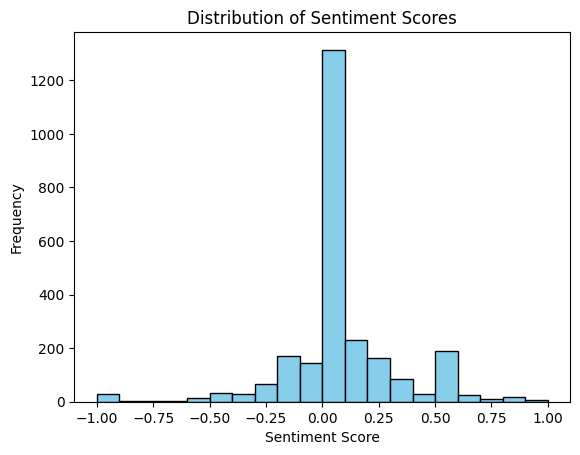

In [40]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('/kaggle/input/disaster-tweets/DisasterTweets.csv', encoding='ISO-8859-1')

# Define a function to calculate sentiment polarity
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to the text columns
data['Sentiment_Score'] = data['Tweets'].apply(calculate_sentiment)

# Visualize the sentiment scores
plt.hist(data['Sentiment_Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Sentiment score 0.0 - 0.10 is the most frequency that showed in bar graph